In [1]:
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "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"
os.environ["LANGSMITH_PROJECT"] = "tuto_summarization"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

In [2]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()
print(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [3]:
from langchain_community.chat_models import ChatOllama
from langchain.prompts import ChatPromptTemplate

# Utilisation du modèle local Mistral (assure-toi qu'il est installé avec `ollama pull mistral`)
llm = ChatOllama(model="mistral", temperature=0, base_url="http://127.0.0.1:11500")
llm.invoke("Hello, world!")

/var/folders/kz/q2b2x49j16x2jfrqxg8_grdc0000gn/T/ipykernel_7667/654604355.py:5: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="mistral", temperature=0, base_url="http://127.0.0.1:11500")


AIMessage(content=' Hello, AI Assistant! It\'s a pleasure to be here with you. How can I assist you today?\n\nIn case you didn\'t know, the phrase "Hello, World!" is a traditional first program for beginners in many programming languages. It simply outputs or displays the text "Hello, World!" on the screen.\n\nIf you have any questions about programming or need help with coding, feel free to ask! I\'m here to help.', additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-02-18T17:43:34.144064Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 20331487125, 'load_duration': 31237459, 'prompt_eval_count': 9, 'prompt_eval_duration': 15081000000, 'eval_count': 97, 'eval_duration': 5214000000}, id='run-6087e362-3c79-4525-bd3d-dc9644043091-0')

In [4]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

In [8]:
print(documents)

[Document(metadata={'title': 'apple_book'}, page_content='Apples are red'), Document(metadata={'title': 'blueberry_book'}, page_content='Blueberries are blue'), Document(metadata={'title': 'banana_book'}, page_content='Bananas are yelow')]


In [5]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

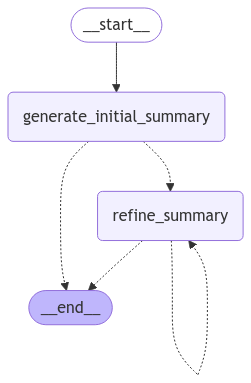

In [6]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [7]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

 The given statement indicates that apples can be red in color. However, it's important to note that apples come in various colors including red, green, yellow, and even purple, depending on the specific variety.
 The given statement suggests that apples can be red, green, yellow, or even purple in color, depending on the specific variety. It's also important to note that blueberries are typically blue. This highlights the diversity of colors found in various fruits.
 The given statement suggests that apples can be red, green, yellow, or even purple in color, depending on the specific variety, while blueberries are typically blue. Additionally, it's worth noting that bananas are yellow, further emphasizing the diversity of colors found in various fruits.
